In [1]:
import csv
import pandas as pd
import matplotlib as plt
import  numpy as np
import seaborn as sns
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB

In [2]:
df=pd.read_csv('../data_preprocess/spanish_networkx.csv')
df.head()

,language,language_code,sentence_id,n,vertex,degree_cent,closeness_cent,betweenness_cent,pagerank_cent,eigenvector_cent,katz_cent,is_root
0,Spanish,17,2,17,3,0.1875,6.634524,0.341667,0.090343,0.256511,0.267647,0
1,Spanish,17,2,17,14,0.1875,7.159524,0.566667,0.086008,0.327129,0.270111,0
2,Spanish,17,2,17,13,0.1250,5.717857,0.125000,0.063707,0.179381,0.243115,0
3,Spanish,17,2,17,10,0.0625,4.348016,0.000000,0.035899,0.079192,0.218559,0
4,Spanish,17,2,17,6,0.1250,6.700000,0.525000,0.057677,0.305101,0.247868,0


In [3]:
import pandas as pd


# The original dataframe with added rankings
ranked_df = df.copy()
for sentence_id, group in df.groupby('sentence_id'):
    ranked_df.loc[group.index, 'degree_rank'] = group['degree_cent'].rank(ascending=False, method='min').astype(int)
    ranked_df.loc[group.index, 'closeness_rank'] = group['closeness_cent'].rank(ascending=False, method='min').astype(int)
    ranked_df.loc[group.index, 'betweenness_rank'] = group['betweenness_cent'].rank(ascending=False, method='min').astype(int)
    ranked_df.loc[group.index, 'pagerank_rank'] = group['pagerank_cent'].rank(ascending=False, method='min').astype(int)
    ranked_df.loc[group.index, 'eigenvector_rank'] = group['eigenvector_cent'].rank(ascending=False, method='min').astype(int)
    ranked_df.loc[group.index, 'katz_rank'] = group['eigenvector_cent'].rank(ascending=False, method='min').astype(int)

In [4]:
ranked_df[ranked_df['is_root']==1]

,language,language_code,sentence_id,n,vertex,degree_cent,closeness_cent,betweenness_cent,pagerank_cent,eigenvector_cent,katz_cent,is_root,degree_rank,closeness_rank,betweenness_rank,pagerank_rank,eigenvector_rank,katz_rank
14,Spanish,17,2,17,9,0.125000,5.398016,0.125000,0.065629,0.140658,0.242866,1,5.0,9.0,8.0,6.0,13.0,13.0
20,Spanish,17,5,13,6,0.166667,5.050000,0.409091,0.081135,0.069249,0.279806,1,3.0,7.0,5.0,4.0,10.0,10.0
30,Spanish,17,8,48,8,0.106383,15.610354,0.679926,0.045226,0.566397,0.193422,1,1.0,1.0,1.0,1.0,1.0,1.0
78,Spanish,17,11,21,18,0.250000,10.650000,0.678947,0.110695,0.577787,0.288265,1,1.0,1.0,1.0,1.0,1.0,1.0
99,Spanish,17,12,22,3,0.095238,7.178968,0.380952,0.044513,0.255207,0.215893,1,6.0,7.0,6.0,13.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10441,Spanish,17,989,27,9,0.076923,7.304762,0.076923,0.040915,0.072784,0.188875,1,6.0,18.0,12.0,10.0,17.0,17.0
10468,Spanish,17,990,35,11,0.117647,11.122619,0.593583,0.053463,0.085096,0.199807,1,2.0,2.0,1.0,5.0,15.0,15.0
10503,Spanish,17,992,20,10,0.105263,6.535714,0.105263,0.053520,0.124755,0.224561,1,4.0,9.0,9.0,7.0,12.0,12.0
10523,Spanish,17,994,45,44,0.068182,13.302814,0.489429,0.031192,0.299454,0.166873,1,5.0,4.0,3.0,10.0,3.0,3.0


In [5]:
ranked_df.to_csv('ranked_spanish1.csv')

In [11]:
df = pd.read_csv('ranked_spanish1.csv')

In [8]:
import numpy as np
import networkx as nx
from scipy.stats import zscore
def engineer_graph_features(df, G=None):
    """
    Engineer additional features from the graph and centrality metrics.

    Args:
        df: DataFrame with network data
        G: NetworkX graph (optional)

    Returns:
        DataFrame with additional engineered features
    """
    # Make a copy to avoid modifying the original
    enhanced_df = df.copy()

    # Combine centrality scores
    enhanced_df['closeness_pagerank_ratio'] = enhanced_df['closeness_cent'] / (enhanced_df['pagerank_cent'] + 1e-6)
    enhanced_df['eigen_betweenness_product'] = enhanced_df['eigenvector_cent'] * enhanced_df['betweenness_cent']
    enhanced_df['degree_closeness_ratio'] = enhanced_df['degree_cent'] / (enhanced_df['closeness_cent'] + 1e-6)
    enhanced_df['pagerank_katz_ratio'] = enhanced_df['pagerank_cent'] / (enhanced_df['katz_cent'] + 1e-6)

    # Apply logarithmic transformation to handle skewness
    enhanced_df['log_betweenness'] = np.log1p(enhanced_df['betweenness_cent'])
    enhanced_df['log_pagerank'] = np.log1p(enhanced_df['pagerank_cent'])

    # Boolean features based on medians
    enhanced_df['high_closeness'] = (enhanced_df['closeness_cent'] > enhanced_df['closeness_cent'].median()).astype(int)
    enhanced_df['high_betweenness'] = (enhanced_df['betweenness_cent'] > enhanced_df['betweenness_cent'].median()).astype(int)
    enhanced_df['high_eigenvector'] = (enhanced_df['eigenvector_cent'] > enhanced_df['eigenvector_cent'].median()).astype(int)

    # Z-score normalization
    centrality_cols = ['closeness_cent', 'pagerank_cent', 'betweenness_cent', 'eigenvector_cent', 'degree_cent', 'katz_cent']
    z_score_cols = [f"{col.split('_')[0]}_z" for col in centrality_cols]

    for col, z_col in zip(centrality_cols, z_score_cols):
        enhanced_df[z_col] = zscore(enhanced_df[col], nan_policy='omit')

    # Combinations of z-scores
    enhanced_df['closeness_pagerank_z_sum'] = enhanced_df['closeness_z'] + enhanced_df['pagerank_z']
    enhanced_df['eigen_betweenness_z_product'] = enhanced_df['eigenvector_z'] * enhanced_df['betweenness_z']

    # Rank-based features
    enhanced_df['min_rank'] = enhanced_df[['degree_rank', 'closeness_rank', 'betweenness_rank',
                                         'pagerank_rank', 'eigenvector_rank', 'katz_rank']].min(axis=1)
    enhanced_df['max_rank'] = enhanced_df[['degree_rank', 'closeness_rank', 'betweenness_rank',
                                         'pagerank_rank', 'eigenvector_rank', 'katz_rank']].max(axis=1)
    enhanced_df['rank_range'] = enhanced_df['max_rank'] - enhanced_df['min_rank']
    enhanced_df['avg_rank'] = enhanced_df[['degree_rank', 'closeness_rank', 'betweenness_rank',
                                         'pagerank_rank', 'eigenvector_rank', 'katz_rank']].mean(axis=1)

    # If we have a graph, we can compute additional graph-based features
    if G is not None:
        # Initialize new columns
        enhanced_df['clustering_coef'] = 0.0
        enhanced_df['eccentricity'] = 0.0
        enhanced_df['num_leaf_neighbors'] = 0

        # Compute clustering coefficients
        clustering_coeffs = nx.clustering(G)

        # Compute eccentricity (maximum path length from node to any other node)
        try:
            eccentricity = nx.eccentricity(G)
        except nx.NetworkXError:
            # If the graph is not connected, we'll assign -1 to eccentricity
            eccentricity = {node: -1 for node in G.nodes()}

        # Find leaf nodes (nodes with degree 1)
        leaf_nodes = [node for node, degree in dict(G.degree()).items() if degree == 1]

        # For each node in our dataframe
        for _, row in enhanced_df.iterrows():
            vertex = row['vertex']
            if vertex in G:
                # Update clustering coefficient
                enhanced_df.loc[enhanced_df['vertex'] == vertex, 'clustering_coef'] = clustering_coeffs.get(vertex, 0)

                # Update eccentricity
                enhanced_df.loc[enhanced_df['vertex'] == vertex, 'eccentricity'] = eccentricity.get(vertex, -1)

                # Count leaf neighbors
                neighbors = list(G.neighbors(vertex))
                leaf_count = sum(1 for n in neighbors if n in leaf_nodes)
                enhanced_df.loc[enhanced_df['vertex'] == vertex, 'num_leaf_neighbors'] = leaf_count

    return enhanced_df

In [9]:
import networkx as nx
def create_graph(df, sentence_id):
    """
    Create a NetworkX graph for a specific sentence ID.

    Args:
        df: DataFrame with network data
        sentence_id: ID of the sentence to create a graph for

    Returns:
        NetworkX graph
    """
    # Filter dataframe for the specific sentence
    sentence_df = df[df['sentence_id'] == sentence_id]

    # Create an empty graph
    G = nx.Graph()

    # Add nodes to the graph
    for _, row in sentence_df.iterrows():
        G.add_node(row['vertex'], is_root=row['is_root'])

    # Since we don't have edge information, we'll create a simple
    # connected graph based on vertex IDs for demonstration
    # In a real scenario, you would use actual edge data

    # For simplicity, connect each node to the next one
    nodes = list(G.nodes())
    for i in range(len(nodes) - 1):
        G.add_edge(nodes[i], nodes[i+1])

    # Add some additional edges to create a more interesting graph
    if len(nodes) > 2:
        # Connect first node to the last node to create a cycle
        G.add_edge(nodes[0], nodes[-1])

        # Add a few more edges
        for i in range(0, len(nodes) - 2, 2):
            G.add_edge(nodes[i], nodes[i+2])

    return G

In [12]:
# Try to create a graph if we have all needed data
try:
    # Get a unique sentence ID (for demonstration)
    sample_sentence_id = df['sentence_id'].iloc[0]

    # Create a graph for this sentence
    G = create_graph(df, sample_sentence_id)

    # Engineer additional features using the graph
    enhanced_df = engineer_graph_features(df, G)

    print("\nCreated graph and engineered graph-based features")
except Exception as e:
    print(f"\nCould not create graph: {e}")
    # Engineer features without graph data
    enhanced_df = engineer_graph_features(df)
    print("\nEngineered features without graph data")


Created graph and engineered graph-based features


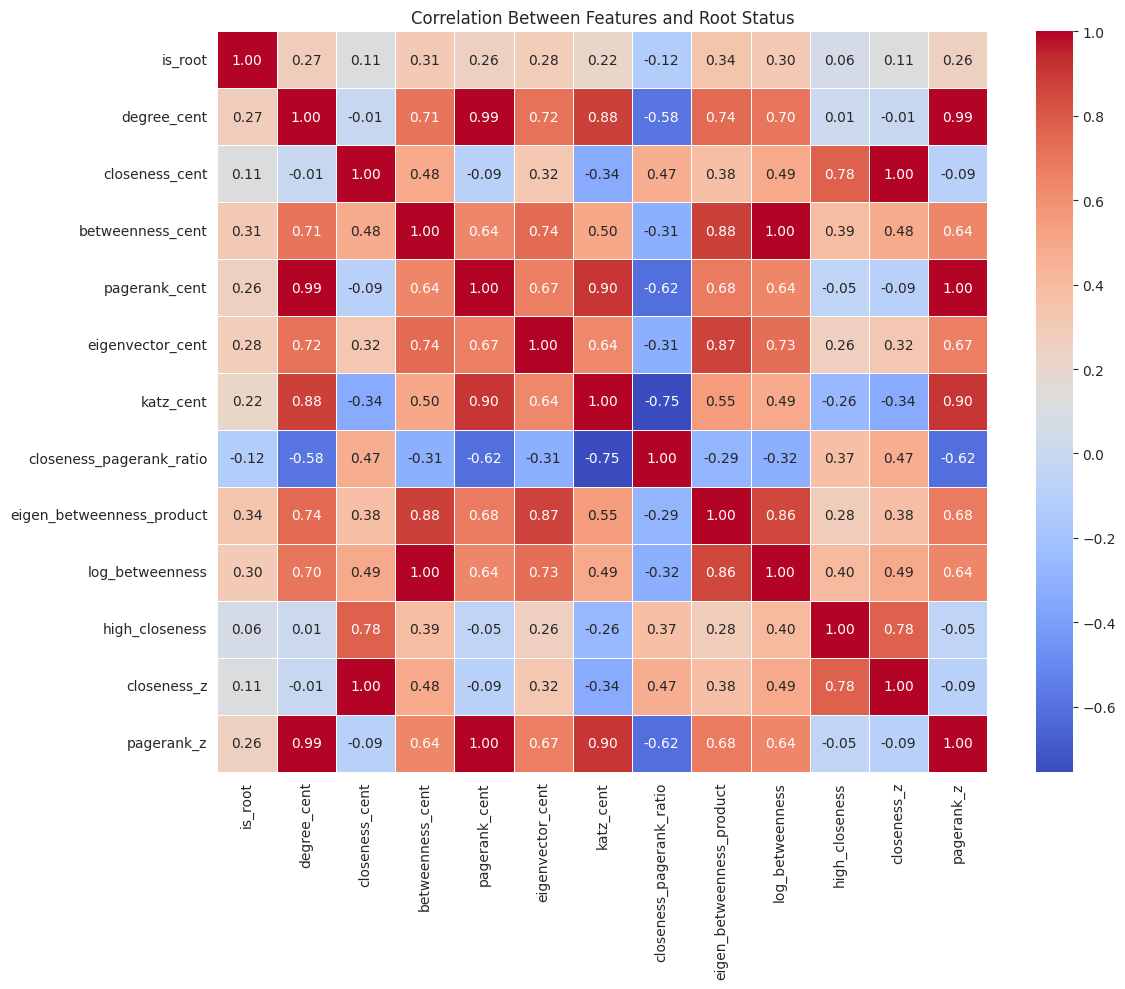

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualize correlations between features and target
plt.figure(figsize=(12, 10))
corr_cols = ['is_root', 'degree_cent', 'closeness_cent', 'betweenness_cent',
             'pagerank_cent', 'eigenvector_cent', 'katz_cent',
             'closeness_pagerank_ratio', 'eigen_betweenness_product',
             'log_betweenness', 'high_closeness', 'closeness_z', 'pagerank_z']

# Only include columns that exist in the dataframe
corr_cols = [col for col in corr_cols if col in enhanced_df.columns]

# Calculate correlations
corr = enhanced_df[corr_cols].corr()
# Create heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Between Features and Root Status')
plt.tight_layout()

In [14]:
# Select features for the model
# Identity features
identity_features = ['language', 'language_code', 'sentence_id', 'n', 'vertex']
# Basic centrality features
basic_features = [
    'degree_cent', 'closeness_cent', 'betweenness_cent',
    'pagerank_cent', 'eigenvector_cent', 'katz_cent',
    'degree_rank', 'closeness_rank', 'betweenness_rank',
    'pagerank_rank', 'eigenvector_rank', 'katz_rank'
]

# Engineered features
engineered_features = [
    'closeness_pagerank_ratio', 'eigen_betweenness_product',
    'degree_closeness_ratio', 'pagerank_katz_ratio',
    'log_betweenness', 'log_pagerank',
    'high_closeness', 'high_betweenness', 'high_eigenvector',
    'closeness_z', 'pagerank_z', 'betweenness_z',
    'eigenvector_z', 'degree_z', 'katz_z',
    'closeness_pagerank_z_sum', 'eigen_betweenness_z_product',
    'min_rank', 'max_rank', 'rank_range', 'avg_rank'
]

# Graph-based features (if available)
graph_features = ['clustering_coef', 'eccentricity', 'num_leaf_neighbors']

# Combine all features, but only include those that exist in the dataframe
all_features = basic_features + engineered_features + graph_features
feature_columns = [feat for feat in all_features if feat in enhanced_df.columns]

In [15]:
print("\nSelected features for modeling:")
for i, feat in enumerate(feature_columns, 1):
    print(f"{i}. {feat}")

# Prepare data for modeling
X = enhanced_df[feature_columns]
y = enhanced_df['is_root']

# Handle NaN values (if any)
X = X.fillna(X.mean())


Selected features for modeling:
1. degree_cent
2. closeness_cent
3. betweenness_cent
4. pagerank_cent
5. eigenvector_cent
6. katz_cent
7. degree_rank
8. closeness_rank
9. betweenness_rank
10. pagerank_rank
11. eigenvector_rank
12. katz_rank
13. closeness_pagerank_ratio
14. eigen_betweenness_product
15. degree_closeness_ratio
16. pagerank_katz_ratio
17. log_betweenness
18. log_pagerank
19. high_closeness
20. high_betweenness
21. high_eigenvector
22. closeness_z
23. pagerank_z
24. betweenness_z
25. eigenvector_z
26. degree_z
27. katz_z
28. closeness_pagerank_z_sum
29. eigen_betweenness_z_product
30. min_rank
31. max_rank
32. rank_range
33. avg_rank
34. clustering_coef
35. eccentricity
36. num_leaf_neighbors


In [16]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.model_selection import GroupKFold, cross_val_score, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN

# Prepare data for modeling
X = enhanced_df[feature_columns]
y = enhanced_df['is_root']
groups = enhanced_df['sentence_id']  # Use sentence_id as grouping variable

# Analyze class imbalance
class_counts = y.value_counts()
imbalance_ratio = class_counts[0] / class_counts[1] if 1 in class_counts else float('inf')
print(f"\nClass imbalance ratio (non-root:root): {imbalance_ratio:.2f}:1")



Class imbalance ratio (non-root:root): 20.19:1


In [17]:
enhanced_df.to_csv('engineered_features.csv', index=False, header=True)